<a href="https://colab.research.google.com/github/IImbryk/NMA_MindBigData/blob/work/mnist_for_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Work plan:\
Step 1. Our task. Data description \
Step 2. Load datasets\
Step 3. \


# 1. Our task. Data description

*Predicting the number that a person sees according to EEG data* \
[dataset](http://www.mindbigdata.com/opendb/)

* [id]: a numeric, only for reference purposes.

* [event] id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

* [device]: a 2 character string, to identify the device used to capture the signals, "MW" for MindWave, "EP" for Emotive Epoc, "MU" for Interaxon Muse & "IN" for Emotiv Insight.

* [channel]: a string, to indentify the 10/20 brain location of the signal, with possible values:
 
MindWave	"FP1"
EPOC	"AF3, "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"
Muse	"TP9,"FP1","FP2", "TP10"
Insight	"AF3,"AF4","T7","T8","PZ" 

* [code]: a integer, to indentify the digit been thought/seen, with possible values 0,1,2,3,4,5,6,7,8,9 or -1 for random captured signals not related to any of the digits.

* [size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

* [data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

from google.colab import drive


# Imports
import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm, trange


from scipy.interpolate import interp1d
from scipy import arange
import numpy as np

In [3]:
drive.mount('/content/drive', force_remount=True)
path_dir = '/content/drive/MyDrive/Data Brain MNIST' 

path_dir_test = '/content/drive/MyDrive/Data Science/Neuromatch Academy/input_test'

Mounted at /content/drive


In [4]:
file_name =  ['/MindBigData-EP-v1.0/EP1.01.txt',
              '/MindBigData-IN-v1.06/IN.txt',
              '/MindBigData-MU-v1.0/MU.txt',
              '/MindBigData-MW-v1.0/MW.txt']

<a id='step_2'></a>
# 2. Load data 


In [5]:
#load data from 4 files
data_EP1 = pd.read_csv(path_dir+file_name[0], sep="\t", header=None)
# data_IN = pd.read_csv(path_dir+file_name[1], sep="\t", header=None)
# data_MU = pd.read_csv(path_dir+file_name[2], sep="\t", header=None)
# data_MW = pd.read_csv(path_dir+file_name[3], sep="\t", header=None) #, nrows=99)
# df = pd.concat([data_EP1, data_IN, data_MU, data_MW], ignore_index=True)
#data = data_2.copy(deep=True)

In [6]:


scalers = {}

def scaler_data(scalers, X_train, X_test, X_val):
  for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = torch.tensor(scalers[i].fit_transform(X_train[:, i, :]))

  for i in range(X_test.shape[1]):
    X_test[:, i, :] = torch.tensor(scalers[i].transform(X_test[:, i, :]))


  for i in range(X_val.shape[1]):
    X_val[:, i, :] = torch.tensor(scalers[i].transform(X_val[:, i, :]))
    return X_train, X_test, X_val, scalers

#**Beginning of code secsion**

In [91]:
def interpolation_data(df, max_eeg_len):
  df_copy = df.copy(deep=True)

  for i in df.index:
    if df['size'][i]==max_eeg_len:
      continue
    x = np.arange(0, df['size'][i])
    f = interp1d(x, df['data'][i])
    
    new_step = np.linspace(0, df['size'][i]-1, num=max_eeg_len)
    eeg_inter = f(new_step)
    df_copy.at[i,'data'] = eeg_inter
    df_copy.at[i,'size'] = max_eeg_len
  return df_copy


def parse_str_(data_inp, max_len):
  """
  without add zero
  
  """
  data = data_inp.copy(deep=True)
  for i in range(0, len(data)):
    eeg = list(map(float, data['data'][i].split(',')))
    data['data'][i] = eeg
  return data

def check_shuffle_data(labels_in_sample, labels=torch.arange(0, 10)):
  """
  выводит сообщение, если в выборке нет представителя какого-то класса. 
  """
  if not (torch.equal(labels,labels_in_sample.unique())):
    print('The sample does not include a representative of each class')


def data_preprocessing(dataset, samples_num=21, interpolation=True, val=True, scalers=scalers):
  df = dataset.copy(deep=True)
  columns_rename = {0: 'id',
                    1: 'event',
                    2: 'device',
                    3: 'channel',
                    4: 'code',
                    5: 'size',
                    6: 'data'}
  df = df.rename(columns=columns_rename)
  return df
  df_clean = df.query('size>247 and size<273').reset_index()
  df_clean = parse_str_(df_clean[0:samples_num*14], 260)
  if interpolation:
    df_clean = interpolation_data(df_clean, max_eeg_len=int(df_clean['size'].median()))
  df_groupby = df_clean.groupby(df_clean['event'])
  df_data = df_groupby['data'].apply(lambda x: np.array([y for y in x]))
  
  df_code = torch.tensor(df_groupby['code'].apply(max).to_numpy())
  df_data = torch.tensor(np.array([x for x in df_data.to_numpy()])).float()
  try:
    X_train, X_test, y_train, y_test = train_test_split(df_data, df_code, shuffle=True, train_size=0.7, stratify=df_code)
  except:
    X_train, X_test, y_train, y_test = train_test_split(df_data, df_code, shuffle=True, train_size=0.7)
  if val:
    try:
      X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, shuffle=True, train_size=0.5, stratify=y_test)
    except:
      X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, shuffle=True, train_size=0.5)
    print(*list(map(lambda x: x.size(), (X_train, y_train, X_val, y_val, X_test, y_test))))
    check_shuffle_data(y_train)
    check_shuffle_data(y_val)
    check_shuffle_data(y_test)
    # m1, m2, m3 = scaler_data(scalers, X_train, X_test)

    # print(m1)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)
  else:
    print(*list(map(lambda x: x.size(), (X_train, y_train, X_test, y_test))))
    check_shuffle_data(y_train)
    check_shuffle_data(y_val)
    check_shuffle_data(y_test)
    return (X_train, y_train), (X_test, y_test)


class DriveData(Dataset):
    def __init__(self, X, y, transform=None):
        self.x_data = X
        self.y_data = y
    def __getitem__(self,index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.y_data.size(0)

# dset_train = DriveData()
# train_loader = DataLoader(dset_train, batch_size=4,shuffle=True, num_workers=2)




def initialize_weights(m):
  return 0

In [92]:
df_raw = data_preprocessing(data_EP1, samples_num=10000, interpolation=True)

In [94]:
df_raw.head()

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"4395.384615,4382.564102,4377.435897,4387.17948..."
1,67636,67635,EP,F7,6,260,"4489.230769,4475.384615,4474.358974,4486.66666..."
2,67637,67635,EP,F3,6,260,"4538.461538,4528.717948,4524.615384,4526.15384..."
3,67638,67635,EP,FC5,6,260,"4207.692307,4205.641025,4200.512820,4194.35897..."
4,67639,67635,EP,T7,6,260,"4497.948717,4498.461538,4494.871794,4497.94871..."


In [39]:
train1, val1, test1 = data_preprocessing(data_EP1, samples_num=10000, interpolation=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([7000, 14, 260]) torch.Size([7000]) torch.Size([1500, 14, 260]) torch.Size([1500]) torch.Size([1500, 14, 260]) torch.Size([1500])


In [40]:
tr, te, va, scalers = scaler_data(scalers, train1[0], test1[0], val1[0])

In [41]:
train = (tr, train1[1])
test = (te, test1[1])
val = (tr, val1[1])

In [42]:
dset_train = DriveData(*train)
train_loader = DataLoader(dset_train,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

dset_val = DriveData(*val)
val_loader = DataLoader(dset_val,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

dset_test = DriveData(*test)
test_loader = DataLoader(dset_test,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

## CNN from article

In [43]:
class CNN_net_ch(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """
  def __init__(self, in_dim, out_dim, kernel_size=1, padding=0):
    super().__init__()

    # in_channels (int): Number of channels in the input
    # out_channels (int): Number of channels produced by the convolution
    # kernel_size (int or tuple): Size of the convolving kernel
    # padding (int or tuple, optional): Zero-padding added to both sides of
    #     the input. Default: 0

    # self.conv1 = nn.Conv2d(in_channels=14, out_channels=28, kernel_size=kernel_size, \
                          #  padding=padding)
    # self.conv2 = nn.Conv2d(in_channels=28, out_channels=28, kernel_size=(1,2), \
                          #  padding=padding)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=25, kernel_size=[1,11]) # in article 
    self.conv2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=[2,1]) # in article 
    
    self.bn = nn.BatchNorm2d(25)
    self.pool1 = nn.MaxPool2d(3)

    self.conv3 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=[1,11]) # in article 
    self.pool2 = nn.MaxPool2d(3)

    self.conv4 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=[1,11]) # in article 
    self.bn2 = nn.BatchNorm2d(100)

    # self.pool3 = nn.MaxPool2d(3)
    # self.conv5 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=[1,11]) # in article 

    # self.bn3 = nn.BatchNorm2d()
    # self.pool4 = nn.MaxPool2d(2)
    # self.dropout1 = nn.Dropout()
    self.fc1 = nn.Linear(1400,10)

    self.ln = nn.LayerNorm(10,10)
    # self.fc1 = nn.Linear(in_dim-kernel_size+1,1)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x) #leaky_relu
    x = self.conv2(x)
    x = self.bn(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.conv4(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = torch.flatten(x,1)

    # x = self.fc1(x)
    # x = F.relu(x)
    x = self.fc1(x)
    x = self.ln(x)
    return x

In [72]:
lr = 0.01 # learning rate
n_epochs = 25
dim_input = dset_train.x_data.size(2)
dim_output = 10
losses = np.zeros(n_epochs)  # loss records

model = CNN_net_ch(dim_input, dim_output)

criterion = nn.CrossEntropyLoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_loss, val_loss = [], []
train_acc, val_acc = [], []

for i in range(n_epochs):
  loss_sum, total_correct = 0, 0
  
  # train loop
  model.train()
  for id, (x_batch, y_batch) in enumerate(train_loader):
    optimizer.zero_grad()
    # print(x_batch.shape)
    output = model(x_batch.unsqueeze(1))
    loss = criterion(output, y_batch)
    loss_sum += loss.item()
    predictions = torch.argmax(output, dim=1)
    num_correct = torch.sum(predictions == y_batch)
    total_correct += num_correct
    loss.backward()
    optimizer.step()

  train_loss.append(loss_sum/(id+1))
  train_acc.append(total_correct/len(dset_train))

  loss_sum, total_correct = 0, 0
  # val loop
  model.eval()
  with torch.no_grad():
    for id, (x_batch, y_batch) in enumerate(val_loader):
      output = model(x_batch.unsqueeze(1))
      loss = criterion(output, y_batch)
      loss_sum += loss.item()
      predictions = torch.argmax(output, dim=1)
      num_correct = torch.sum(predictions == y_batch)
      total_correct += num_correct
  
  val_loss.append(loss_sum/id)
  val_acc.append(total_correct/len(dset_val))
  
  
  # IPython.display.clear_output(wait=True)
  # IPython.display.display(plt.gcf())
  
  print(f'For {i} epoch: train loss {train_loss[i]}, acc {train_acc[i]} {total_correct};'#)
        f' val loss {val_loss[i]}, acc {val_acc[i]}')  
  # if i == 3:
  #   break


For 0 epoch: train loss 2.3279070687198584, acc 0.10214285552501678 155; val loss 2.312773765089678, acc 0.10333333164453506
For 1 epoch: train loss 2.311503700149475, acc 0.09399999678134918 152; val loss 2.313919910135116, acc 0.10133333504199982
For 2 epoch: train loss 2.3112227642720193, acc 0.09457142651081085 154; val loss 2.314670739326885, acc 0.10266666859388351
For 3 epoch: train loss 2.308890447949191, acc 0.10528571158647537 154; val loss 2.3117853020601733, acc 0.10266666859388351
For 4 epoch: train loss 2.310140115182832, acc 0.09114285558462143 143; val loss 2.316403216856686, acc 0.09533333033323288
For 5 epoch: train loss 2.3101546922501597, acc 0.10014285892248154 155; val loss 2.318655923726087, acc 0.10333333164453506
For 6 epoch: train loss 2.310154084275967, acc 0.1047142893075943 146; val loss 2.3174700635002257, acc 0.09733333438634872
For 7 epoch: train loss 2.310615849535829, acc 0.09785714000463486 153; val loss 2.3121611593878844, acc 0.10199999809265137
For

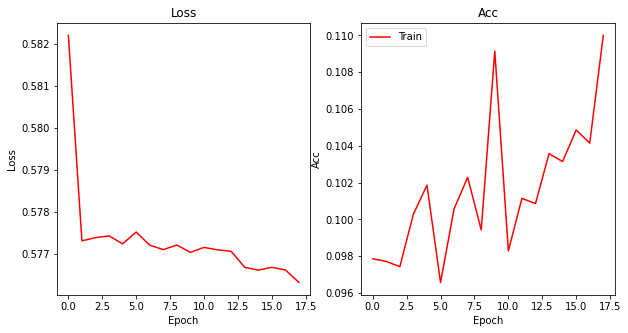

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (train_data, title) in zip(axs, ((train_loss, 'Loss'),
                                                   (train_acc,'Acc'))):
  # ax.plot(val_data, label='Val', c='red', ls = 'dashed')
  ax.plot(train_data, label='Train', c='red', ls = 'solid')
  # ax.set_title('Batch size: ' + str(batch_size))
  ax.set_xlabel('Epoch')
  ax.set_ylabel(title)
  ax.set_title(title)
plt.legend()
plt.show()

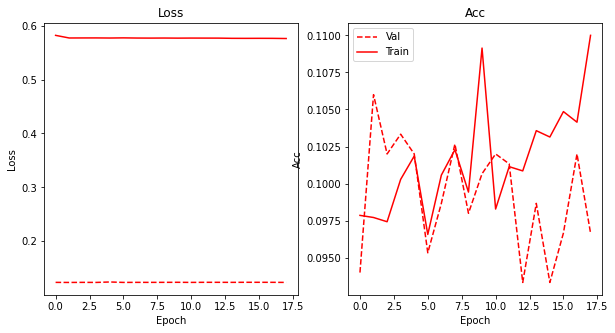

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (train_data, val_data, title) in zip(axs, ((train_loss, val_loss, 'Loss'),
                                                   (train_acc, val_acc, 'Acc'))):
  ax.plot(val_data, label='Val', c='red', ls = 'dashed')
  ax.plot(train_data, label='Train', c='red', ls = 'solid')
  # ax.set_title('Batch size: ' + str(batch_size))
  ax.set_xlabel('Epoch')
  ax.set_ylabel(title)
  ax.set_title(title)
plt.legend()
plt.show()

In [66]:
train_loader.dataset.x_data.shape[0]

7000

In [69]:
for id, (x_batch, y_batch) in enumerate(train_loader):
  print(x_batch.shape)

torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])
torch.Size([4, 14, 260])


KeyboardInterrupt: ignored

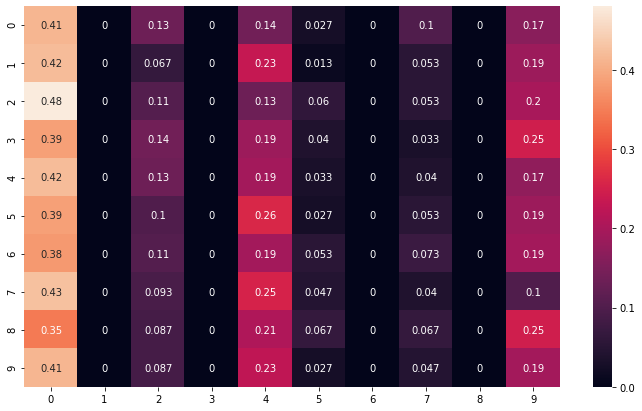

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for id, (x_batch, y_batch) in enumerate(test_loader):
  output = model(x_batch.unsqueeze(1))
  labels = y_batch
  output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(output) # Save Prediction
  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = np.arange(0,10)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
len(train_data)

25

In [ ]:
df = data_EP1.copy(deep=True)

In [ ]:
columns_rename = {0: 'id', 1: 'event',
                 2: 'device', 3:'channel',
                 4: 'code', 5: 'size', 6:'data'}

In [ ]:
def rename_columns(data):
  data = data.rename(columns=columns_rename)
  return data

In [ ]:
df = rename_columns(df)
# data_MW = rename_columns(data_MW)
# data_EP1 = rename_columns(data_EP1)
# data_MU = rename_columns(data_MU)
# data_IN = rename_columns(data_IN)

In [ ]:
df.head()

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"4395.384615,4382.564102,4377.435897,4387.17948..."
1,67636,67635,EP,F7,6,260,"4489.230769,4475.384615,4474.358974,4486.66666..."
2,67637,67635,EP,F3,6,260,"4538.461538,4528.717948,4524.615384,4526.15384..."
3,67638,67635,EP,FC5,6,260,"4207.692307,4205.641025,4200.512820,4194.35897..."
4,67639,67635,EP,T7,6,260,"4497.948717,4498.461538,4494.871794,4497.94871..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910476 entries, 0 to 910475
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       910476 non-null  int64 
 1   event    910476 non-null  int64 
 2   device   910476 non-null  object
 3   channel  910476 non-null  object
 4   code     910476 non-null  int64 
 5   size     910476 non-null  int64 
 6   data     910476 non-null  object
dtypes: int64(4), object(3)
memory usage: 48.6+ MB


# CNN from article test

In [ ]:
class CNN_net_ch(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """
  def __init__(self, in_dim, out_dim, kernel_size=1, padding=0):
    super().__init__()

    # in_channels (int): Number of channels in the input
    # out_channels (int): Number of channels produced by the convolution
    # kernel_size (int or tuple): Size of the convolving kernel
    # padding (int or tuple, optional): Zero-padding added to both sides of
    #     the input. Default: 0

    # self.conv1 = nn.Conv2d(in_channels=14, out_channels=28, kernel_size=kernel_size, \
                          #  padding=padding)
    # self.conv2 = nn.Conv2d(in_channels=28, out_channels=28, kernel_size=(1,2), \
                          #  padding=padding)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=[1,11]) # in article 

    self.dropout1 = nn.Dropout(0.4)
    self.conv2 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=[2,1]) # in article 

    self.bn = nn.BatchNorm2d(20)
    self.pool1 = nn.MaxPool2d(3)

    self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=[1,11]) # in article 
    self.dropout2 = nn.Dropout(0.4)
    self.pool2 = nn.MaxPool2d(3)

    self.conv4 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=[1,11]) # in article 
    self.bn2 = nn.BatchNorm2d(80)
    self.dropout3 = nn.Dropout(0.4)

    self.pool3 = nn.MaxPool2d(3)
    self.conv5 = nn.Conv2d(in_channels=80, out_channels=160, kernel_size=[1,11]) # in article 

    self.bn3 = nn.BatchNorm2d(160)
    #self.pool4 = nn.MaxPool2d(3)
    # 
    self.fc1 = nn.Linear(640,10)

    # self.ln = nn.LayerNorm(10,10)
    # self.fc1 = nn.Linear(in_dim-kernel_size+1,1)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x) #leaky_relu
    #x = self.dropout1(x)

    x = self.conv2(x)
    x = self.bn(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv3(x)
    x = F.relu(x)
    #x = self.dropout2(x)
    x = self.pool2(x)

    x = self.conv4(x)
    x = self.bn2(x)
    x = F.relu(x)
    #x = self.dropout3(x)
    # print(x.shape)

    #x = self.pool3(x) #cout 
    #print(x.shape)
    x = self.conv5(x)

    x = self.bn3(x)

    x = F.leaky_relu(x)
    #print(x.shape)

    # x = self.pool4(x)

    x = torch.flatten(x,1)


    x = self.fc1(x)

    return x

In [ ]:
lr = 0.01 # learning rate
n_epochs = 25
dim_input = dset_train.x_data.size(2)
dim_output = 10
losses = np.zeros(n_epochs)  # loss records

model = CNN_net_ch(dim_input, dim_output)

criterion = nn.CrossEntropyLoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_loss, val_loss = [], []
train_acc, val_acc = [], []

for i in range(n_epochs):
  loss_sum, total_correct = 0, 0
  
  # train loop
  model.train()
  for id, (x_batch, y_batch) in enumerate(train_loader):
    optimizer.zero_grad()
    # print(x_batch.shape)
    output = model(x_batch.unsqueeze(1))
    loss = criterion(output, y_batch)
    loss_sum += loss.item()
    predictions = torch.argmax(output, dim=1)
    num_correct = torch.sum(predictions == y_batch)
    total_correct += num_correct
    loss.backward()
    optimizer.step()

  train_loss.append(loss_sum)
  train_acc.append(total_correct/len(dset_train))

  loss_sum, total_correct = 0, 0
  # val loop
  model.eval()
  with torch.no_grad():
    for id, (x_batch, y_batch) in enumerate(val_loader):
      output = model(x_batch.unsqueeze(1))
      loss = criterion(output, y_batch)
      loss_sum += loss.item()
      predictions = torch.argmax(output, dim=1)
      num_correct = torch.sum(predictions == y_batch)
      total_correct += num_correct
  
  val_loss.append(loss_sum)
  val_acc.append(total_correct/len(dset_val))
  
  
  # IPython.display.clear_output(wait=True)
  # IPython.display.display(plt.gcf())
  
  print(f'For {i} epoch: train loss {train_loss[i]}, acc {train_acc[i]} {total_correct};'#)
        f' val loss {val_loss[i]}, acc {val_acc[i]}')  
  # if i == 3:
  #   break

For 0 epoch: train loss 4179.731443762779, acc 0.10114285349845886 156; val loss 927.8279943466187, acc 0.10400000214576721
For 1 epoch: train loss 4042.277307987213, acc 0.09385713934898376 146; val loss 923.3888385295868, acc 0.09733333438634872
For 2 epoch: train loss 4050.0039907693863, acc 0.09585714340209961 143; val loss 944.6239378452301, acc 0.09533333033323288
For 3 epoch: train loss 4059.1672159433365, acc 0.09728571772575378 147; val loss 1525.7307773828506, acc 0.09799999743700027
For 4 epoch: train loss 4061.337673664093, acc 0.0998571440577507 144; val loss 1146.4590212106705, acc 0.09600000083446503
For 5 epoch: train loss 4060.4643704891205, acc 0.09828571230173111 149; val loss 1054.2913521528244, acc 0.09933333098888397


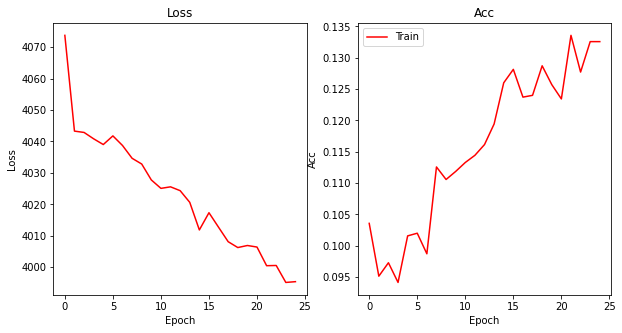

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (train_data, title) in zip(axs, ((train_loss, 'Loss'),
                                                   (train_acc,'Acc'))):
  # ax.plot(val_data, label='Val', c='red', ls = 'dashed')
  ax.plot(train_data, label='Train', c='red', ls = 'solid')
  # ax.set_title('Batch size: ' + str(batch_size))
  ax.set_xlabel('Epoch')
  ax.set_ylabel(title)
  ax.set_title(title)
plt.legend()
plt.show()

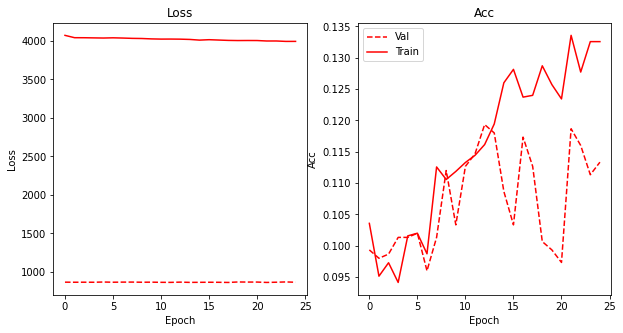

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (train_data, val_data, title) in zip(axs, ((train_loss, val_loss, 'Loss'),
                                                   (train_acc, val_acc, 'Acc'))):
  ax.plot(val_data, label='Val', c='red', ls = 'dashed')
  ax.plot(train_data, label='Train', c='red', ls = 'solid')
  # ax.set_title('Batch size: ' + str(batch_size))
  ax.set_xlabel('Epoch')
  ax.set_ylabel(title)
  ax.set_title(title)
plt.legend()
plt.show()

# 3. Preparing data

In [73]:
k = data_EP1[data_EP1[4]!=-1]

In [82]:
k.shape[0]/14

64875.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feccb9ce410>]],
      dtype=object)

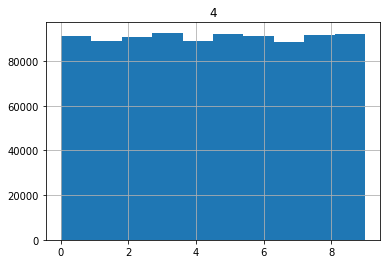

In [75]:
k.hist(4) # с распределениями по классам нет проблем

In [ ]:
df['size'].value_counts(sort=0)

136        14
196        14
204        14
212        14
224        14
228        14
232        14
240        14
244        42
248       196
249        70
252      4956
253       294
256    173614
257     12362
260    606214
261     44072
264     61586
265      3640
268      2884
269        98
272       196
273        14
276        56
280        14
284        14
292        28
320        14
Name: size, dtype: int64

In [ ]:
df_clean = df.query('size>247 and size<273').reset_index()
print('Number of column in input dataset\n{}'.format(len(df)))
print('Number of column in new dataset\n{}'.format(len(df_clean)))

Number of column in input dataset
910476
Number of column in new dataset
910182


In [ ]:
def merge_data(df1, df2):
  # data['event'].value_counts()
  """
  column EVENT don't intersection in 4 files.
  """
  df3 = df1.merge(df2, left_on="event", right_on="event", how="inner")
  print(df3["event"])

In [ ]:
# mat = np.matrix(data[6][0].split(",")[0:max_len])
# for i in range(1, len(data)):
  # mat = np.append(mat,np.matrix(data[6][i].split(",")[0:max_len]), axis=0)
# df_new = pd.concat([data, pd.DataFrame(mat, columns=columns_name)], axis=1)

In [ ]:
###Polina 
# list_of_names = ['id', 'event', 'device','channel', 'code', 'size', 'data']
# df= pd.read_csv('gdrive/My Drive/Data Brain MNIST/MindBigData-MW-v1.0/MW.txt', delimiter = "\t", names = list_of_names)
# for i in range(len(df['data'])):
  # df['data'][i] = df['data'][i].split(',') ###uncomment for the first time only 
  # for j in range(len(df['data'][i])):
    # df['data'][i][j] = int(df['data'][i][j])

In [ ]:
def parse_str(data_inp, max_len):
  """

  with add zero
  
  """
  data = data_inp.copy(deep=True)
  for i in range(0, len(data)):
    eeg = list(map(int, data['data'][i].split(',')))
    zero_add = [0] * (max_len - len(eeg))
    data['data'][i] = eeg + zero_add
  return data

In [ ]:
def parse_str_(data_inp, max_len):
  """
  without add zero
  
  """
  data = data_inp.copy(deep=True)
  for i in range(0, len(data)):
    eeg = list(map(float, data['data'][i].split(',')))
    data['data'][i] = eeg
  return data

In [ ]:
#df_parse= parse_str(df, df['size'].max())

In [ ]:
df_clean = parse_str_(df_clean[0:300], 256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
def print_signal(df, column_name='data'):
  numb_size = 14

  plt.figure(figsize=(16,6))
  plt.ylabel('Amplitude of the signal', size=numb_size)
  plt.xlabel('time, ms', size=numb_size)
  number = df['code'].values[0]
  plt.title(f'EEG signal for 1 person (seen number {number})', size=numb_size)

  for i in df.index:
     plt.plot(np.linspace(0, 2/df['size'][i]*10**3,df['size'][i]),df[column_name][i], label=df['channel'][i])
  plt.legend()

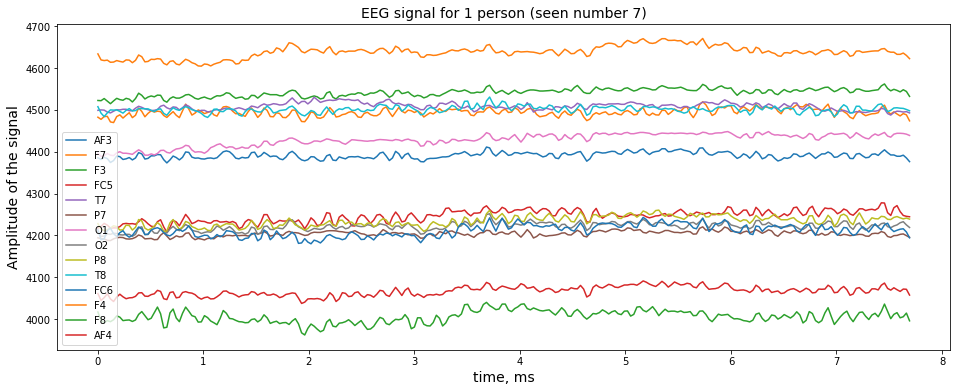

In [ ]:
print_signal(df_clean.query('code==7')[0:14])

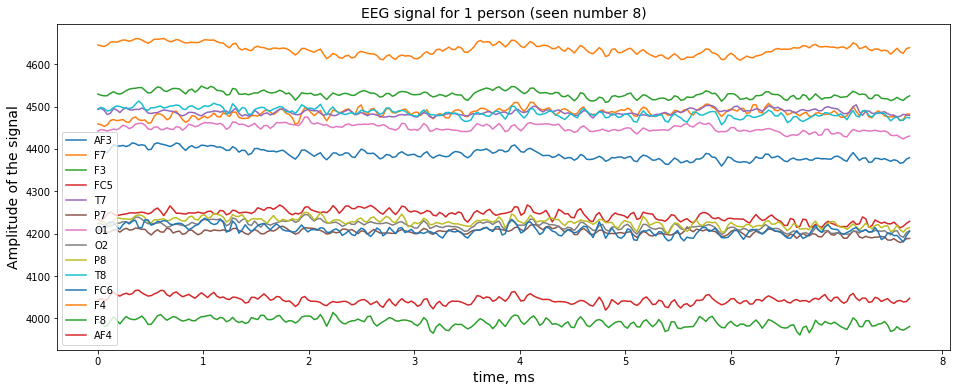

In [ ]:
print_signal(df_clean.query('code==8')[0:14])

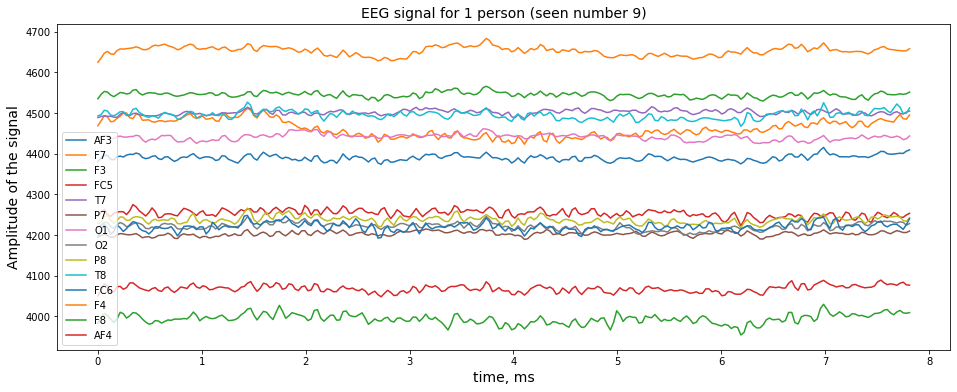

In [ ]:
print_signal(df_clean.query('code==9')[0:14])

In [ ]:
from scipy.interpolate import interp1d
import numpy as np


def interpolation_data(df, max_eeg_len):
  df_copy = df.copy(deep=True)

  for i in df.index:
    if df['size'][i]==max_eeg_len:
      continue
    x = np.arange(0, df['size'][i])
    f = interp1d(x, df['data'][i])
    
    new_step = np.linspace(0, df['size'][i]-1, num=max_eeg_len)
    eeg_inter = f(new_step)
    df_copy.at[i,'data'] = eeg_inter
    df_copy.at[i,'size'] = max_eeg_len

    
  return df_copy

In [ ]:
df_interpolation = interpolation_data(df_clean, max_eeg_len=int(df_clean['size'].median()))

In [ ]:
# # фильтрация - пока не нужна!
# from scipy.interpolate import Rbf

# y = data['data'][1]

# rbf = Rbf(range(0,max_len), y, function = 'quintic', smooth = 10)

# xnew = np.linspace(0, max_len, num = 100, endpoint = True)
# ynew = rbf(xnew)

# plt.figure()
# plt.plot(y)
# plt.plot(xnew, ynew, 'r')
# plt.show()

# Train linear model

In [ ]:
class LNNet(nn.Module):
  """A Linear Neural Net with one hidden layer
  """

  def __init__(self, in_dim, hid_dim, out_dim):
    """
    Args:
      in_dim (int): input dimension
      out_dim (int): ouput dimension
      hid_dim (int): hidden dimension
    """
    super().__init__()
    self.in_hid = nn.Linear(in_dim, hid_dim, bias=False)
    self.hid_out = nn.Linear(hid_dim, out_dim, bias=False)

  def forward(self, x):
    """
    Args:
      x (torch.Tensor): input tensor
    """
    hid = self.in_hid(x)  # hidden activity
    out = self.hid_out(hid)  # output (prediction)
    return out, hid


In [ ]:
def train(model, inputs, targets, n_epochs, lr, illusory_i=0):
  """Training function

  Args:
    model (torch nn.Module): the neural network
    inputs (torch.Tensor): features (input) with shape `[batch_size, input_dim]`
    targets (torch.Tensor): targets (labels) with shape `[batch_size, output_dim]`
    n_epochs (int): number of training epochs (iterations)
    lr (float): learning rate
    illusory_i (int): index of illusory feature

  Returns:
    np.ndarray: record (evolution) of training loss
    np.ndarray: record (evolution) of singular values (dynamic modes)
    np.ndarray: record (evolution) of representational similarity matrices
    np.ndarray: record of network prediction for the last feature
  """
  in_dim = inputs.size(1)
  losses = np.zeros(n_epochs)  # loss records

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)

    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    losses[i] = loss.item()

  return losses

In [ ]:
def plot_loss(loss_array, title="Training loss (Mean Squared Error)", c="r"):
  plt.figure(figsize=(10, 5))
  plt.plot(loss_array, color=c)
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.title(title)
  plt.show()

In [ ]:
# split into train test sets
y = torch.tensor([data_MW_copy['code']]).float().T
X = torch.tensor(data_MW_copy['data']).float() # data_EP1.drop(columns=['id', 'event', 'code'], axis=1) 

label_tensor = torch.tensor(data_MW_copy['data']).float()
feature_tensor = torch.tensor([data_MW_copy['code']]).float().T


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# train_set_orig, test_set_orig= torch.utils.data.random_split(X, [len(X)-10000, 10000])

# BATCH_SIZE = 1
# # Create the corresponding DataLoaders for training and test
# g_seed = torch.Generator()

# train_loader = torch.utils.data.DataLoader(train_set_orig,
#                                            shuffle=True,
#                                            batch_size=BATCH_SIZE,
#                                            num_workers=2,
#                                            generator=g_seed)
# test_loader = torch.utils.data.DataLoader(test_set_orig,
#                                           batch_size=256,
#                                           num_workers=2,
#                                           generator=g_seed)

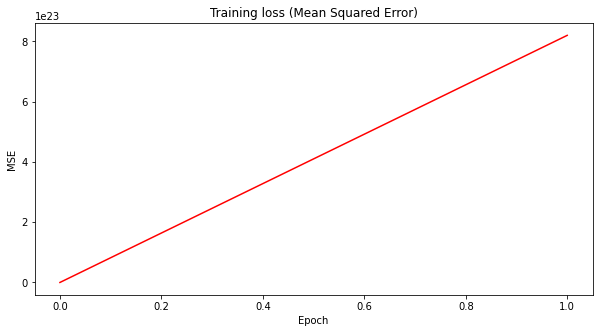

In [ ]:
lr = 10.0 # learning rate
gamma = 1e-12  # initialization scale
n_epochs = 250  # number of epochs
dim_input = X_train.size(1)
dim_hidden = 1024# 1017 # hidden neurons
dim_output = y_train.size(1)  # output dimension = `feature_tensor.size(1)`

# model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# weights re-initialization
# initializer_(dlnn_model, gamma)
# training
losses = train(dlnn_model,
                  X_train,
                  y_train,
                  n_epochs=n_epochs,
                  lr=lr)

# plotting
plot_loss(losses)

# MNE Lib (https://mne.tools/)

try this example:https://www.kaggle.com/broach/getting-started-with-mne-python-and-subs-1-to-24/data?scriptVersionId=13939515&select=time.csv

doc: https://github.com/mne-tools/mne-python

In [73]:
!pip install -U mne

     |████████████████████████████████| 6.9 MB 4.5 MB/s 


In [89]:
list(data_EP1[3].unique())

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

Creating RawArray with float64 data, n_channels=14, n_times=260
    Range : 0 ... 259 =      0.000 ...     0.518 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


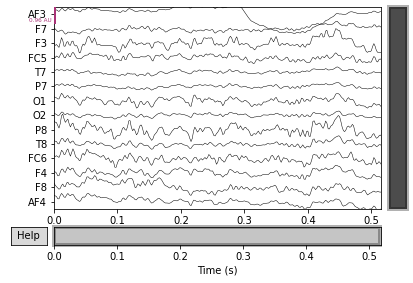

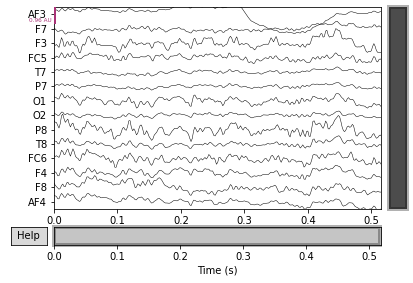

In [90]:
import numpy as np
import mne

# Read the CSV file as a NumPy array
data = data_EP1

# Some information about the channels
ch_names = list(data_EP1[3].unique())  # TODO: finish this list

# Sampling rate of the Nautilus machine
sfreq = 500  # Hz

# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq)

# Finally, create the Raw object
raw = mne.io.RawArray(train[0][0], info)

# Plot it!
raw.plot()

In [74]:
import mne

In [75]:
import numpy as np
import pandas as pd
from mne import EpochsArray
from mne.channels import make_standard_montage #read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
#from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [76]:
col_names = pd.read_csv(path_dir_test+'/columnLabels.csv')

In [77]:
col_names

,subject,trial,condition,sample,Fp1,AF7,AF3,F1,F3,F5,F7,FT7,FC5,FC3,FC1,C1,C3,C5,T7,TP7,CP5,CP3,CP1,P1,P3,P5,P7,P9,PO7,PO3,O1,Iz,Oz,POz,Pz,CPz,Fpz,Fp2,AF8,AF4,AFz,Fz,F2,F4,F6,F8,FT8,FC6,FC4,FC2,FCz,Cz,C2,C4,C6,T8,TP8,CP6,CP4,CP2,P2,P4,P6,P8,P10,PO8,PO4,O2,VEOa,VEOb,HEOL,HEOR,Nose,TP10


In [78]:
ch_names = list(col_names.columns[4:])
#ch_names = montage.ch_names
# define the channel type, where the first 64 are EEG, next 4 are EOG, then Nose,
#and finally right mastoid (EEG)
ch_type = ['eeg']*64 + ['eog']*4 + ['misc'] + ['eeg']
    
# The sampling rate of the recording
sfreq = 1024  # in Hertz (samples per second)

#print(ch_names)
# read EEG standard montage from mne
montage = make_standard_montage('standard_1005')

# Initialize required fields
info = create_info(ch_names=ch_names, sfreq=20, ch_types=ch_type)
#for debugging:
fname = path_dir_test + '/1.csv'

In [79]:
#define the function:
def creat_mne_epoch_object(fname, info):
    """Create a mne epoch instance from csv file"""
    # Add some more information
    info['description'] = 'dataset from ' + fname
    
    # Trials were cut from -1.5 to 1.5 seconds
    tmin = -1.5

    # Read EEG file
    data = pd.read_csv(fname, header=None)
    #print(data)
    #and convert it to numpy array:
    npdata = np.array(data)
    
    #the first 4 columns of the data frame are the
    #subject number... subNumber = npdata[:,0]
    #trial number... trialNumber = npdata[:,1]
    #condition number... conditions = npdata[:,2]
    #and sample number (within a trial)... sampleNumber = npdata[:,3]
    
    #sample 1537 is time 0, use that for the event 
    onsets = np.array(np.where(npdata[:,3]==1537))
    conditions = npdata[npdata[:,3]==1537,2]



    #use these to make an events array for mne (middle column are zeros):
    events = np.squeeze(np.dstack((onsets.flatten(), np.zeros(conditions.shape),conditions)))
    #print(events)

    #now we just need EEGdata in a 3D shape (n_epochs, n_channels, n_samples)
    EEGdata = npdata.reshape(len(conditions),3072,74)
    #remove the first 4 columns (non-eeg, described above):
    EEGdata = EEGdata[:,:,4:]
    EEGdata = np.swapaxes(EEGdata,1,2)
    
    #create labels for the conditions, 1, 2, and 3:
    event_id = dict(button_tone=1, playback_tone=2, button_alone=3)
    
    # create raw object 
    custom_epochs = EpochsArray(EEGdata, info=info, events=events.astype('int'), tmin=tmin, event_id=event_id)
    return custom_epochs

In [80]:
custom_epochs = creat_mne_epoch_object(fname, info)

Not setting metadata
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [81]:
custom_epochs

Number of events,289
Events,button_alone: 95button_tone: 100playback_tone: 94
Time range,-1.500 – 152.050 sec
Baseline,off


In [ ]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 69])

In [ ]:
picks = pick_types(custom_epochs.info,eeg=True)
    
    #could not filter epochs with mne 0.13, upgraded to 0.15 to get this to work:
    # Filter data for alpha frequency and beta band
    # Note that MNE implements a zero phase (filtfilt) filer
custom_epochs.filter(2,6, picks=picks, method='iir', n_jobs=-1, verbose=False)
    

Number of events,289
Events,button_alone: 95button_tone: 100playback_tone: 94
Time range,-1.500 – 152.050 sec
Baseline,off


In [ ]:
pick_types(custom_epochs.info,eeg=True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 69])

# CNN

In [ ]:
# split into train test sets
y = torch.tensor([df_interpolation['code']]).float().T
X = torch.tensor(df_interpolation['data']).float() # data_EP1.drop(columns=['id', 'event', 'code'], axis=1) 


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=14*19, test_size=14*2)

In [ ]:
df_interpolation

,index,id,event,device,channel,code,size,data
0,0,67635,67635,EP,AF3,6,260,"[4395.384615, 4382.564102, 4377.435897, 4387.1..."
1,1,67636,67635,EP,F7,6,260,"[4489.230769, 4475.384615, 4474.358974, 4486.6..."
2,2,67637,67635,EP,F3,6,260,"[4538.461538, 4528.717948, 4524.615384, 4526.1..."
3,3,67638,67635,EP,FC5,6,260,"[4207.692307, 4205.641025, 4200.51282, 4194.35..."
4,4,67639,67635,EP,T7,6,260,"[4497.948717, 4498.461538, 4494.871794, 4497.9..."
...,...,...,...,...,...,...,...,...
295,295,67930,67656,EP,F7,1,260,"[4531.794871, 4538.461538, 4538.461538, 4532.3..."
296,296,67931,67656,EP,F3,1,260,"[4546.153846, 4550.76923, 4551.282051, 4552.82..."
297,297,67932,67656,EP,FC5,1,260,"[4277.435897, 4284.102564, 4286.666666, 4283.5..."
298,298,67933,67656,EP,T7,1,260,"[4508.717948, 4510.25641, 4509.230769, 4511.79..."


In [ ]:
# for i in df_interpolation['event'].unique():
  # b = df_interpolation.query('event==@i')
  # print(torch.tensor(b['data']))

In [ ]:
class CNN_net(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """
  def __init__(self, in_dim, out_dim, kernel_size=3, padding=0):
    super().__init__()

    # in_channels (int): Number of channels in the input
    # out_channels (int): Number of channels produced by the convolution
    # kernel_size (int or tuple): Size of the convolving kernel
    # padding (int or tuple, optional): Zero-padding added to both sides of
    #     the input. Default: 0

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size, \
                           padding=padding)
    
    self.fc1 = nn.Linear(in_dim-kernel_size+1,10)
    # self.fc1 = nn.Linear(in_dim-kernel_size+1,1)
    self.pool = nn.MaxPool1d(2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)

    # x = self.pool(x)
    # x = torch.flatten(x,1)
    # x = self.fc1(x)
    # x = F.relu(x)
    x = self.fc1(x)
    return x

In [ ]:
lr = 0.001 # learning rate
n_epochs = 25
dim_input = X_train.size(1)
dim_output = y_train.size(1)
losses = np.zeros(n_epochs)  # loss records

model = CNN_net(dim_input, dim_output)

criterion = nn.MSELoss()# nn.CrossEntropyLoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_loss, validation_loss = [], []
train_acc, validation_acc = [], []


for i in range(n_epochs):
  for ind in range(0, len(X_train)):
    optimizer.zero_grad()
    input = X_train[ind] #torch.unsqueeze(X_train,1)
    predictions = model(input.unsqueeze(0).unsqueeze(0))
    _, out = torch.max(predictions.squeeze(0), 1)# out = torch.argmax(predictions).to(torch.float32)
    out = out.to(torch.float32)
    loss = criterion(out, y_train[ind])
    loss.requires_grad_(True)
    loss.backward()
    optimizer.step()
    losses[i] = loss.item()

In [ ]:
X_train.shape

torch.Size([266, 260])

In [ ]:
X_test.shape

torch.Size([28, 260])

In [ ]:
lr = 0.001 # learning rate
epochs = 20
channel_count = 14

dim_input = X_train.size(1)
dim_output = y_train.size(1)
losses = np.array(0)  # loss records

model = CNN_net_ch(dim_input, dim_output)

criterion = nn.CrossEntropyLoss()#nn.MSELoss()#   - for classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

with tqdm(range(epochs), unit='epoch') as tepochs:
  tepochs.set_description('Training')
  for epoch in tepochs:
     for i in range(0, len(X_train), channel_count):
       optimizer.zero_grad()

       inp = X_train[i:i+channel_count] #.unsqueeze(0).unsqueeze(0)
       predictions = model(inp.unsqueeze(0).unsqueeze(0))

       #_, out = torch.max(predictions,1 )
       #out = out.to(torch.float32)
       loss = criterion(predictions.float(), y_train[i].long())
       loss.requires_grad_(True)
       loss.backward()
       optimizer.step()
       np.append(losses, loss.item())

In [ ]:
## Testing
correct = 0
total = len(X_test)

with torch.no_grad():#21875
  # Iterate through test set minibatchs
  for i in range(0, X_test.size(0), channel_count):
    inp = X_test[i:i+channel_count] 
    out = model(inp.unsqueeze(0).unsqueeze(0))
    # print(out)
    _, predicted = torch.max(out.data, 1)


    correct += torch.sum((predicted == y_test[i]))


print(f'Test accuracy: {correct/total * 100:.2f}%')

Test accuracy: 0.00%


In [ ]:
X_train[0:14].T.shape # 14 - channel, 260 - sampling of each channel

torch.Size([260, 14])

In [ ]:
t = X_train[0:14].T.unsqueeze(2).unsqueeze(0)

In [ ]:
t.shape

torch.Size([1, 260, 14, 1])

In [ ]:
k = nn.Conv2d(in_channels=1, out_channels=11, kernel_size=[1,28], padding=(0,14)) # должна быть одномерная свертка в направлении временной оси

In [ ]:
k.weight.shape

torch.Size([11, 260, 1, 28])

In [ ]:
k(t).shape

torch.Size([1, 11, 14, 2])

In [ ]:
X_article_sample = X_train[0:14][0:2]

In [ ]:
X_article_sample.shape # на входе 2 канала по 260 временных значения каждый (640 в статье) 

torch.Size([2, 260])

In [ ]:
input = X_article_sample.unsqueeze(0).unsqueeze(0)

In [ ]:
input.shape

torch.Size([1, 1, 2, 260])

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=25, kernel_size=[1,11]) # in article 
conv2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=[2,1]) # in article 
# In convolutional layer 1, one-dimensional convolution in thedirection 
# of the temporal axis is carried out, with 25 kernelsof[11, 1, 1, 25]

In [ ]:
conv.weight.shape

torch.Size([25, 1, 1, 11])

In [ ]:
conv2.weight.shape

torch.Size([25, 25, 2, 1])

In [ ]:
conv(input).shape

torch.Size([1, 25, 2, 250])

In [ ]:
conv2(conv(input)).shape

torch.Size([1, 25, 1, 250])

In [ ]:
input

tensor([[[[4395.3848, 4382.5640, 4377.4360, 4387.1797, 4395.8975, 4398.4614,
           4396.9229, 4391.7949, 4391.2822, 4395.8975, 4398.9741, 4396.4102,
           4392.8203, 4392.8203, 4395.3848, 4398.9741, 4394.3589, 4381.5386,
           4376.4102, 4383.5898, 4387.1797, 4388.7178, 4397.9487, 4401.5386,
           4397.9487, 4398.9741, 4398.9741, 4395.8975, 4396.9229, 4398.4614,
           4397.9487, 4396.4102, 4391.7949, 4389.7437, 4389.7437, 4385.6411,
           4387.6924, 4393.8462, 4389.7437, 4381.0259, 4377.9487, 4378.4614,
           4377.4360, 4385.1284, 4393.3335, 4389.2310, 4382.5640, 4378.9741,
           4375.3848, 4378.4614, 4386.1538, 4389.2310, 4393.8462, 4390.2563,
           4374.8716, 4367.6924, 4374.8716, 4384.6152, 4390.7690, 4394.3589,
           4390.7690, 4382.0513, 4381.0259, 4385.6411, 4376.9229, 4365.6411,
           4373.3335, 4377.9487, 4365.1284, 4363.5898, 4375.8975, 4374.3589,
           4368.2051, 4373.3335, 4378.4614, 4375.8975, 4374.3589, 4376.4102,